In [ ]:
!pip install torch-lucent
!pip install torchsummary
!pip install ttach

In [1]:
import Model as md
import Resnet as res
import data as dta
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms as T
from torch.utils.data import DataLoader
from absl import app
from absl import flags
from absl import logging
import os
from tqdm import tqdm

from torch.cuda import amp
import pandas as pd
import math
from torchsummary import summary
#from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
#from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
from matplotlib import pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
encoder = res.ResNet50().to(device)
proj_head = md.Projection_Head(encoder.representation_dim, 1).to(device)
sup_head = md.Supervised_Head(proj_head.output, 5).to(device)

In [3]:
transf_eval = T.Compose([
    T.CenterCrop(520), #395
    T.Resize(112), #112
    T.ToTensor(),
])

In [4]:
astro_ds = dta.AstroDataset('grad_cam0.csv', 'imagenes_clasificadas_nair/', transform=transf_eval)
dataset_astro = DataLoader(astro_ds,batch_size=64, shuffle=False,num_workers=6)
tensors = next(iter(dataset_astro))
tensors = tensors[0]
tensors.shape

torch.Size([50, 3, 112, 112])

In [5]:
checkpoint = torch.load('Torch_exp1_unbalanced/model.pt')
encoder.load_state_dict(checkpoint['encoder'], strict=True)
proj_head.load_state_dict(checkpoint['projection_head'], strict=True)
sup_head.load_state_dict(checkpoint['supervised_head'], strict=True)

<All keys matched successfully>

In [6]:
class AstroModel(nn.Module):
    def __init__(self, encoder, projection_head, supervised_head):
        super(AstroModel, self).__init__()
        self.encoder = encoder
        self.projection_head = projection_head
        self.supervised_head = supervised_head
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.projection_head(x)
        x = self.supervised_head(x)
        return x

In [7]:
model = AstroModel(encoder, proj_head, sup_head)

In [8]:
from PIL import Image
import numpy as np
import scipy.ndimage as nd
import torch
from lucent.optvis import render, param, transform, objectives
from lucent.misc.io import show

In [9]:
@objectives.wrap_objective()
def dot_compare(layer, batch=1, cossim_pow=0):
  def inner(T):
    dot = (T(layer)[batch] * T(layer)[0]).sum()
    mag = torch.sqrt(torch.sum(T(layer)[0]**2))
    cossim = dot/(1e-6 + mag)
    return -dot * cossim ** cossim_pow
  return inner

In [10]:
def feature_inversion(img, layer=None, n_steps=512, cossim_pow=0.0):
    # Convert image to torch.tensor and scale image
    #img = torch.tensor(np.transpose(img, [2, 0, 1])).to(device)
    #upsample = torch.nn.Upsample(224)
    #img = upsample(img)

    obj = objectives.Objective.sum([
    1.0 * dot_compare(layer, cossim_pow=cossim_pow),
    objectives.blur_input_each_step(),
    ])

    # Initialize parameterized input and stack with target image
    # to be accessed in the objective function
    params, image_f = param.image(112)#224)
    def stacked_param_f():
        return params, lambda: torch.stack([image_f()[0], img])

    transforms = [
    transform.pad(8, mode='constant', constant_value=0.5),
    transform.jitter(8),
    transform.random_scale([0.9, 0.95, 1.05, 1.1] + [1]*4),
    transform.random_rotate(list(range(-5, 5)) + [0]*5),
    transform.jitter(2),
    ]

    vis = render.render_vis(model.encoder, obj, stacked_param_f, transforms=transforms, thresholds=(n_steps,), show_image=False, progress=False)

    #show(vis[0][0])

    return vis[0][0]

In [ ]:
#img = np.array(Image.open("dog_cat.png"), np.float32)

layers = ['layer1', 'layer2', 'layer3', 'layer4', ]

In [ ]:
images = []
for layer in layers:
    print(layer)
    vis = feature_inversion(tensors[24].to(device), layer=layer, cossim_pow=1)
    images.append(vis)
    print()

In [ ]:
x = np.array(images)
w = 20
h = 20
fig = plt.figure(figsize=(10, 10))
columns = 2
rows = 2
for i in range(0, columns*rows):
    img = x[i]
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.imshow(img)
plt.tight_layout(pad=0)
plt.savefig('single.png', dpi=100)
plt.show()

In [ ]:
vis.shape

In [ ]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10, 10))
plt.imshow(vis)
plt.axis('off');

In [ ]:
summary(encoder, (3, 224, 224))

In [ ]:
encoder

In [ ]:
encoder.layer1[0].conv1

In [ ]:
vis = feature_inversion(tensors[13].to(device), layer='layer3_0_bn1', cossim_pow=1)

In [11]:
from lucent.modelzoo.util import get_model_layers
names = get_model_layers(encoder)
names

['stem',
 'stem_conv1',
 'stem_bn1',
 'stem_relu',
 'stem_maxpool',
 'layer1',
 'layer1_0',
 'layer1_0_conv1',
 'layer1_0_bn1',
 'layer1_0_conv2',
 'layer1_0_bn2',
 'layer1_0_conv3',
 'layer1_0_bn3',
 'layer1_0_relu',
 'layer1_0_downsample',
 'layer1_0_downsample_0',
 'layer1_0_downsample_1',
 'layer1_1',
 'layer1_1_conv1',
 'layer1_1_bn1',
 'layer1_1_conv2',
 'layer1_1_bn2',
 'layer1_1_conv3',
 'layer1_1_bn3',
 'layer1_1_relu',
 'layer1_2',
 'layer1_2_conv1',
 'layer1_2_bn1',
 'layer1_2_conv2',
 'layer1_2_bn2',
 'layer1_2_conv3',
 'layer1_2_bn3',
 'layer1_2_relu',
 'layer2',
 'layer2_0',
 'layer2_0_conv1',
 'layer2_0_bn1',
 'layer2_0_conv2',
 'layer2_0_bn2',
 'layer2_0_conv3',
 'layer2_0_bn3',
 'layer2_0_relu',
 'layer2_0_downsample',
 'layer2_0_downsample_0',
 'layer2_0_downsample_1',
 'layer2_1',
 'layer2_1_conv1',
 'layer2_1_bn1',
 'layer2_1_conv2',
 'layer2_1_bn2',
 'layer2_1_conv3',
 'layer2_1_bn3',
 'layer2_1_relu',
 'layer2_2',
 'layer2_2_conv1',
 'layer2_2_bn1',
 'layer2_2_con

In [13]:
images = []
for layer in get_model_layers(encoder):
    print(layer)
    vis = feature_inversion(tensors[43].to(device), layer=layer, cossim_pow=1)
    images.append(vis)

stem
stem_conv1
stem_bn1
stem_relu
stem_maxpool
layer1
layer1_0
layer1_0_conv1
layer1_0_bn1
layer1_0_conv2
layer1_0_bn2
layer1_0_conv3
layer1_0_bn3
layer1_0_relu
layer1_0_downsample
layer1_0_downsample_0
layer1_0_downsample_1
layer1_1
layer1_1_conv1
layer1_1_bn1
layer1_1_conv2
layer1_1_bn2
layer1_1_conv3
layer1_1_bn3
layer1_1_relu
layer1_2
layer1_2_conv1
layer1_2_bn1
layer1_2_conv2
layer1_2_bn2
layer1_2_conv3
layer1_2_bn3
layer1_2_relu
layer2
layer2_0
layer2_0_conv1
layer2_0_bn1
layer2_0_conv2
layer2_0_bn2
layer2_0_conv3
layer2_0_bn3
layer2_0_relu
layer2_0_downsample
layer2_0_downsample_0
layer2_0_downsample_1
layer2_1
layer2_1_conv1
layer2_1_bn1
layer2_1_conv2
layer2_1_bn2
layer2_1_conv3
layer2_1_bn3
layer2_1_relu
layer2_2
layer2_2_conv1
layer2_2_bn1
layer2_2_conv2
layer2_2_bn2
layer2_2_conv3
layer2_2_bn3
layer2_2_relu
layer2_3
layer2_3_conv1
layer2_3_bn1
layer2_3_conv2
layer2_3_bn2
layer2_3_conv3
layer2_3_bn3
layer2_3_relu
layer3
layer3_0
layer3_0_conv1
layer3_0_bn1
layer3_0_conv2
la

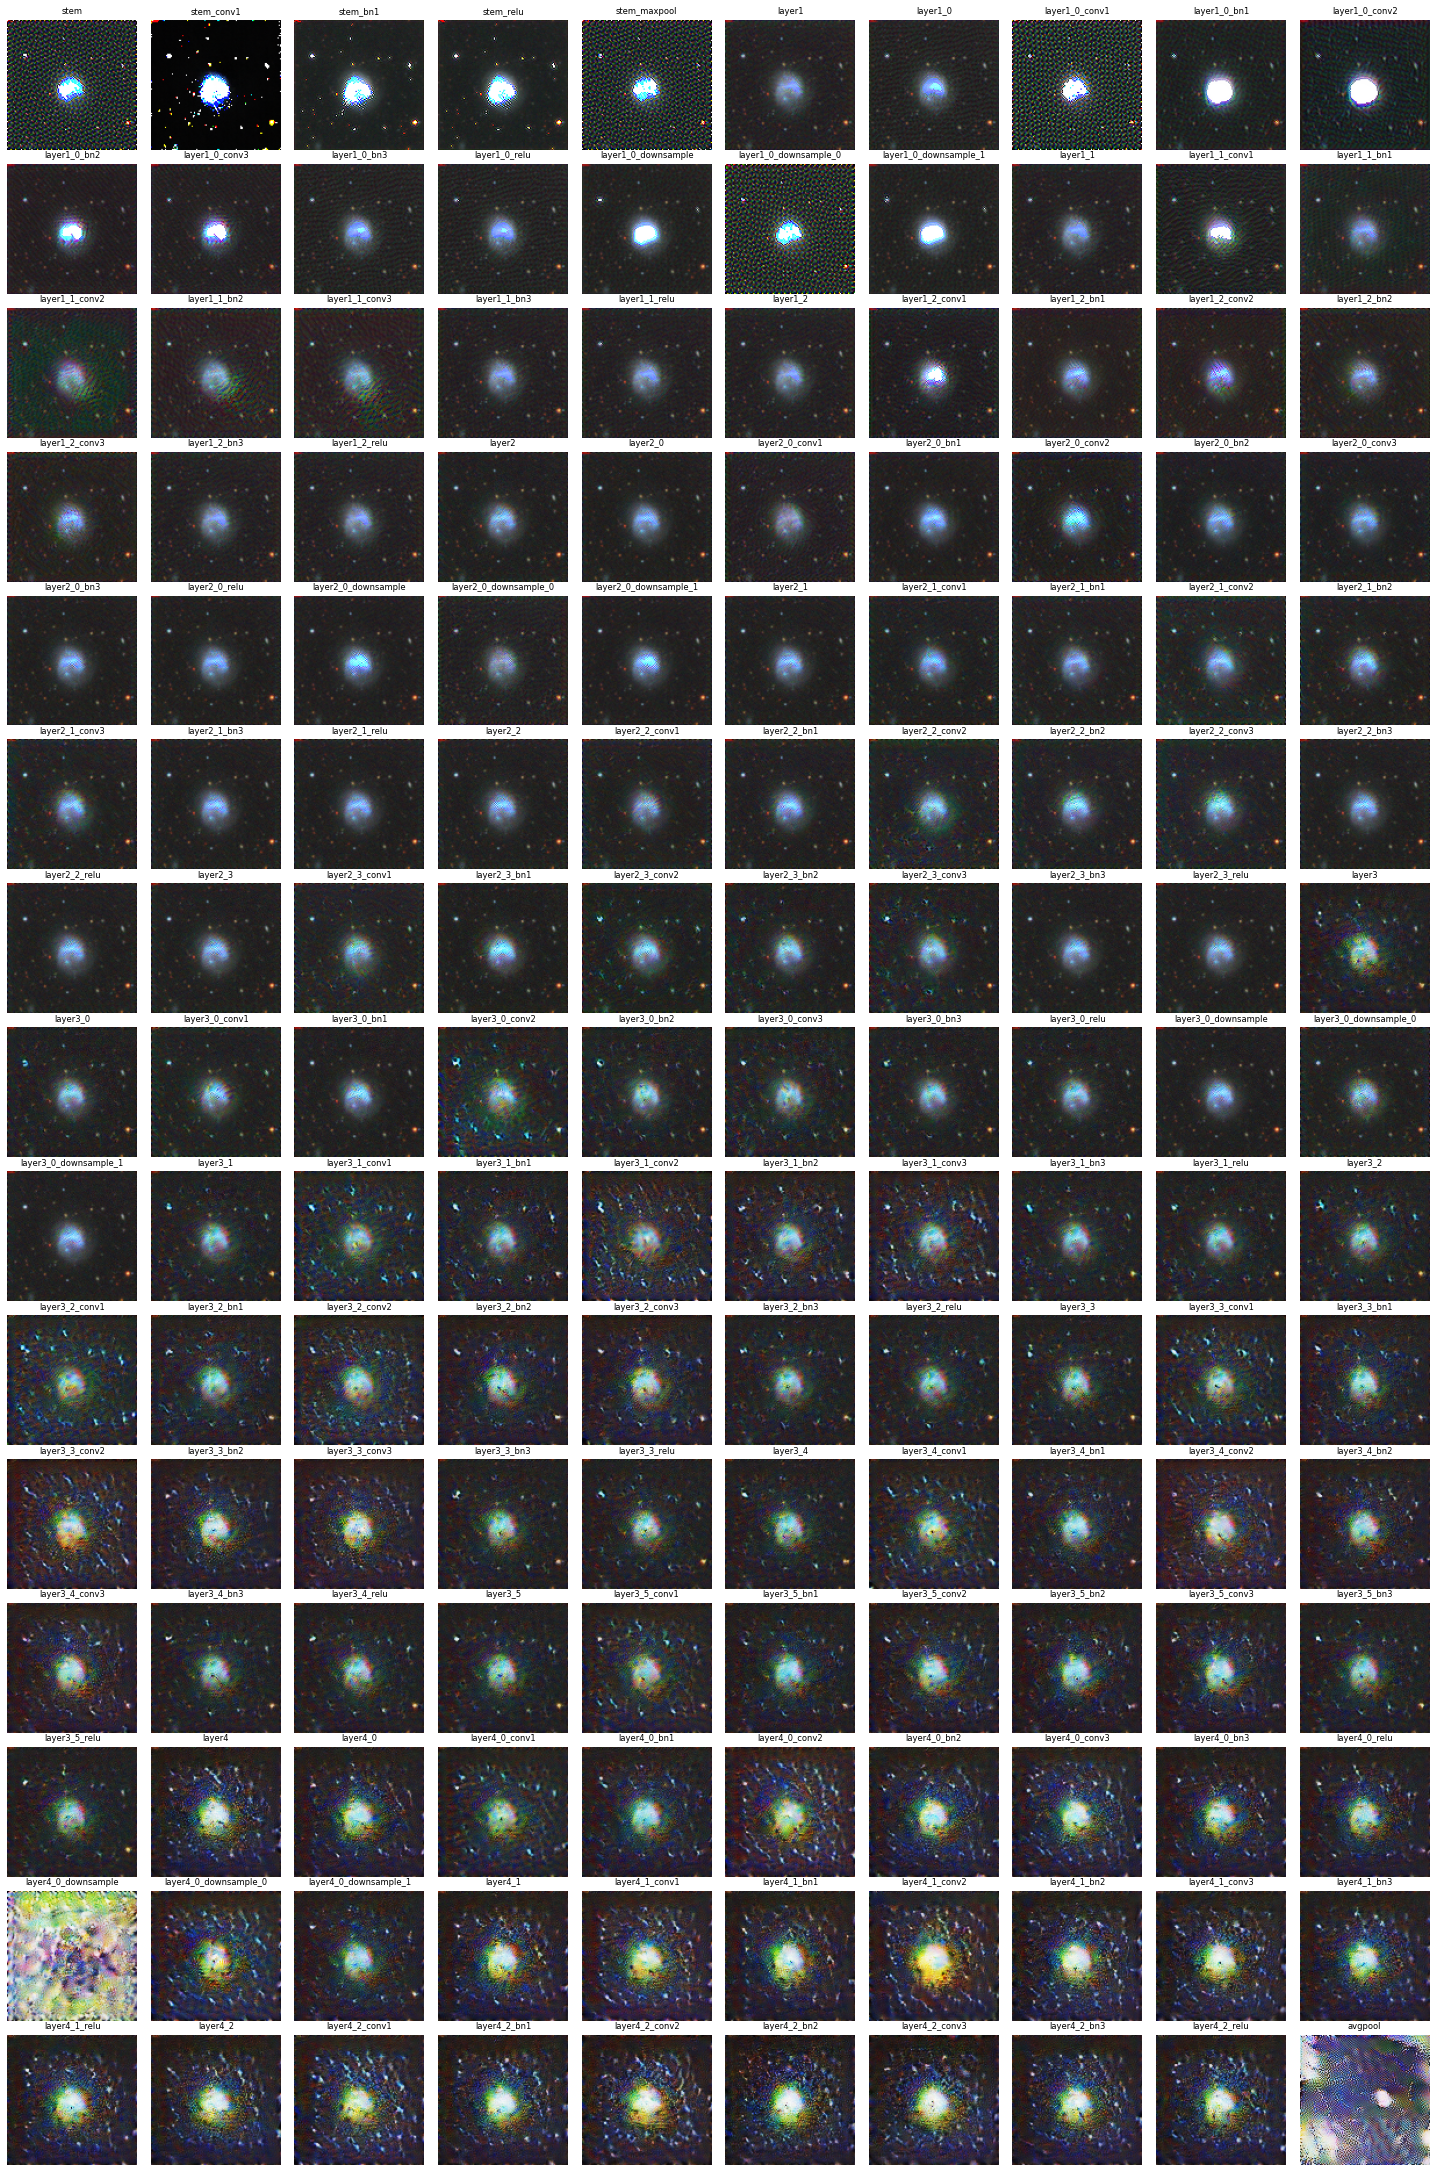

In [14]:
z = np.array(images)
#w = 20
#h = 20
fig = plt.figure(figsize=(20, 30))
columns = 10
rows = 15
for i in range(0, columns*rows):
    img = z[i]
    ax = fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.imshow(img)
    ax.set_title(names[i], fontsize='small', loc='center')
plt.tight_layout(pad=0.1)
plt.savefig('torch_exp1_fine_class4.pdf', bbox_inches = 'tight', pad_inches = 0, format='pdf', dpi=100)
plt.show()

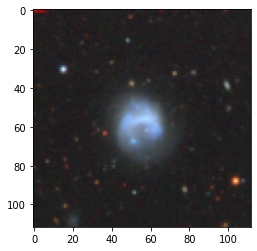

In [12]:
plt.imshow(tensors[43].permute(1, 2, 0));